In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from itertools import permutations, combinations
from sklearn.model_selection import train_test_split

# import itertools

<hr>

### **1)** Five layer perceptron regressor

a) Load the data into a pandas DataFrame, and get a scikit-learn compatible dataset. Use
the “target” column as the target variable.

In [2]:
# Load the dataset
full_data_part1 = pd.read_csv("Part 1.tsv", sep="\t")

# Using only half of the data
partial_data = full_data_part1.head(int(full_data_part1.shape[0]/2))

features = [x for x in partial_data.columns.drop("target")]

X = partial_data[features]
y = partial_data["target"]

In [3]:
partial_data.head(5)

,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,target
0,0.314826,0.876050,-0.685288,0.604524,-0.868619,-0.671283,-59.177636
1,0.662332,0.745420,-0.423713,0.179228,-1.349615,0.355827,-11.643998
2,-0.448170,0.065115,0.107046,0.459968,1.302039,-0.758131,35.562439
3,1.199397,-1.109276,-0.003139,-0.916933,-0.325098,-0.655460,-18.147836
4,-0.066389,1.762515,0.560241,-1.308726,-0.631064,-0.038181,-42.328718


b) Make a 70%/30% split of the dataset for training and testing respectively.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

print(f"Tamanho de treino: {X_train.shape}")
print(f"Tamanho de teste: {X_test.shape}")

Tamanho de treino: (3500, 6)
Tamanho de teste: (1500, 6)


c) Using numpy, create a scikit-learn regressor that implements a multilayer perceptron
architecture with 5 hidden layers.
- The dimensionality of each layer is your decision.
- Each hidden layer must have a bias unit.
- All activations should be the sigmoid function.
- You must use the backpropagation algorithm to calculate the derivatives.
- Use mini-batch gradient descent to update the weights.
- The parameters of the estimator are the following:
    - **learning_rate:** A float number that determines the learning rate used for
updating the weights on the update step of the gradient descent.
    - **batch_size**: An integer that determines the number of datapoints that
are included in each mini-batch.
    - **epochs**: An integer that determines the number of times the training
goes through all the datapoints

In [5]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.estimator_checks import check_estimator
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted


class FiveLayerPerceptronRegressor(BaseEstimator, ClassifierMixin):
    def __init__(self, learning_rate=0.01, batch_size=100, epochs=100, size_hidden=100):
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.size_hidden = size_hidden

        self.rng = np.random.default_rng(0)

        self.training_losses = np.zeros(self.epochs)

    def _sigmoid(self, Z):
        return 1.0 / (1.0 + np.exp(-Z))

    def _sigmoid_derivative(self, Z):
        x = self._sigmoid(Z)
        return x * (1 - x)

    def cost_function(self, y, y_hat):
        return np.sum(np.square(y_hat - y)) * 1/2 

    def cost_gradient(self, y, y_hat):
        return (y_hat - y)

    def _forward_propagation(self, X):
        self.Z = []
        self.A = []

        for i in range(5):
            self.Z.append((X @ self._W[i]))
            self.A.append(self._sigmoid(self.Z[i]))
            self.A[i] = np.c_[np.ones((self.A[i].shape[0],1)), self.A[i]]
            X = self.A[i]
            
        self.Z.append((self.A[-1] @ self._W[-1]))
        self.A.append(self.Z[-1])

        return self.A[-1]

    # function of backward propagation for regression
    def _backward_propagation(self, X, y):
        dA = []
        dW = []
        delta = []
        
        dA.append(self.cost_gradient(y, self.A[-1]))
        delta.append(dA[0])
        dW.append((self.A[-2].T @ delta[0]))
        
        for i in range(5, 1, -1):   
            dA.append((delta[-1] @ self._W[i][1:,:].T))
            delta.append(dA[-1] * self._sigmoid_derivative(self.Z[i-1]))
            dW.append((self.A[i-2].T @ delta[-1]))

        dA.append((delta[-1] @ self._W[1][1:,:].T))
        delta.append(dA[-1] * self._sigmoid_derivative(self.Z[0]))
        dW.append((X.T @ delta[-1]))


        dW.reverse()

        return dW
        
    def _weight_update(self, dW, curr):
        for i in range(len(dW)):
            self._W[i] -= (self.learning_rate * dW[i]) / curr

    def fit(self, X, y):
        n, m = X.shape

        _X = np.c_[np.ones((n,1)), X]
        y = y.to_numpy()
        _y = y[:,np.newaxis]

        self._W = []

        self._W.append(np.random.randn(m+1, self.size_hidden))
        for i in range(4):
            self._W.append(np.random.randn(self.size_hidden+1, self.size_hidden))
        self._W.append(np.random.randn(self.size_hidden+1, 1))

        n_batches = (n + self.batch_size - 1) // self.batch_size

        for epoch in range(self.epochs):
            for b in range(n_batches):
                _X_batch = _X[b * self.batch_size : (b + 1) * self.batch_size]
                _y_batch = _y[b * self.batch_size : (b + 1) * self.batch_size]
                y_pred = self._forward_propagation(_X_batch)
                curr_batch_size = _y_batch.shape[0]
                dW = self._backward_propagation(_X_batch, _y_batch)
                self._weight_update(dW, curr_batch_size)
            y_pred = self._forward_propagation(_X)
            self.training_losses[epoch] = self.cost_function(_y, y_pred)

    def predict(self, X):
        n, m = X.shape
        _X = np.c_[np.ones((n, 1)), X]
        
        return self._forward_propagation(_X)

d) Train the estimator you implemented using the training set. Use the trained estimator
to predict values for the test set.

In [6]:
model = FiveLayerPerceptronRegressor(epochs=100, learning_rate=0.01, batch_size=100)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(y_pred)

[[-280.93209243]
 [ -23.87860032]
 [ -75.86249576]
 ...
 [  25.07713113]
 [ 328.01662631]
 [ 194.89680477]]


e) Use the scikit-learn MLPRegressor estimator. Train it on the training test and generate
predictions for the test set.

In [7]:
from sklearn.neural_network import MLPRegressor
mlp = MLPRegressor(hidden_layer_sizes=(100,), \
    learning_rate_init=0.1, activation="logistic",\
    batch_size=100)
mlp.fit(X_train, y_train)
y_mlp_pred = mlp.predict(X_test)
y_mlp_pred

array([-278.78582288,  -25.84546532,  -77.58219429, ...,   20.75654089,
        333.62770072,  191.99418421])

f) Compare the performance of both models using the mean squared error metric from
scikit-learn

In [8]:
from sklearn.metrics import mean_squared_error
print(mean_squared_error(y_test, y_pred), mean_squared_error(y_test, y_mlp_pred))

16.993113780199046 5.492905920976894


<hr>

### **2)** multi layers perceptron classifier

a) Load the data into a pandas DataFrame, and get a scikit-learn compatible dataset. Use
the “target” column as the target variable

In [9]:
# Load the dataset
full_data_part2 = pd.read_csv("Part 2.tsv", sep="\t")

# Using only half of the data
partial_data_2 = full_data_part2.head(int(full_data_part2.shape[0]))

features_2 = [x for x in partial_data_2.columns.drop("target")]

X_2 = partial_data_2[features_2]
y_2 = partial_data_2["target"]


In [10]:
partial_data_2.head()

,feat_0,feat_1,feat_2,feat_3,target
0,-0.772441,0.360758,-2.381101,0.087570,0.0
1,1.149460,0.622546,0.373029,0.459658,0.0
2,-1.908792,-1.160263,-0.273645,-0.827660,1.0
3,-0.776947,0.314343,-2.262319,0.063391,0.0
4,-1.170471,0.022124,-2.173768,-0.134220,0.0


b) Make a 70%/30% split of the dataset for training and testing respectively

In [11]:

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.30, random_state=0)

print(f"Tamanho de treino: {X_train_2.shape}")
print(f"Tamanho de teste: {X_test_2.shape}")

Tamanho de treino: (7000, 4)
Tamanho de teste: (3000, 4)


c) Using numpy, create a scikit-learn classifier that implements a multilayer perceptron
with the following parameters:
- Each hidden layer must have a bias unit.
- All activations should be the sigmoid function.
- You must use the backpropagation algorithm to calculate the derivatives.
- Use mini-batch gradient descent to update the weights.
- The parameters of the estimator are the following:
    - **hidden_layers_dimensions**: A list of integers that determines the number
and dimensionality of the hidden layers. The number of items on the list
determine the number of hidden layers. The first element of the list (at
index 0) is the dimensionality of the first hidden layer (connected to the
input). The last element is the dimensionality of the hidden layer
(connected to the output layer). The dimensionality does not include the
bias term. The dimensionality of the input and output layers should be
inferred from the dimensionality of the data.
For example: A list [4,3,2] will generate 3 hidden layers with dimensions
4, 3, and 2, respectively. If we count the bias units, the dimensions are 5,
4, 3.
    - **learning_rate**: A float number that determines the learning rate used for
updating the weights in gradient descent.
    - **batch_size**: An integer that determines the number of datapoints that
are included in each mini-batch.
    - **epochs**: An integer that determines the number of times the training
goes through all the datapoints.

In [12]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.estimator_checks import check_estimator
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted


# Class of a neural network for classification
class NeuralNetClass(BaseEstimator, ClassifierMixin):
    def __init__(self, hidden_layer_dimensions, learning_rate, batch_size
                    , epochs):
        self.hidden_layer_dimensions = hidden_layer_dimensions
        self.size_of_hidden = len(hidden_layer_dimensions)
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.epochs = epochs
        self.training_losses = np.zeros(self.epochs)
        self.rng = np.random.default_rng(0)

    def _sigmoid(self, Z):
        return 1.0 / (1.0 + np.exp(-Z))

    def _sigmoid_derivative(self, Z):
        return self._sigmoid(Z) * (1.0 - self._sigmoid(Z))

    def cost_function(self, y, y_hat):
        return -np.mean(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))

    def cost_gradient(self, y, y_hat):
        return -np.divide(y, y_hat) + np.divide(1.0 - y, 1.0 - y_hat)

    def _forward_propagation(self, X):
        self.Z = []
        self.A = []

        for i in range(self.size_of_hidden):
            self.Z.append(np.dot(X, self._W[i]))
            self.A.append(self._sigmoid(self.Z[i]))
            self.A[i] = np.c_[np.ones((self.A[i].shape[0],1)), self.A[i]]
            X = self.A[i]

        self.Z.append(np.dot(self.A[-1], self._W[-1]))
        self.A.append(self._sigmoid(self.Z[-1]))

        return self.A[-1]
        

    def _backward_propagation(self, X, y):
        dA = []
        dW = []
        dZ = []

        dA.append(self.cost_gradient(y, self.A[-1]))
        dZ.append(dA[0] * self._sigmoid_derivative(self.Z[-1]))
        dW.append(self.A[-2].T @ dZ[0])

        for i in range(self.size_of_hidden, 1, -1):
            dA.append(dZ[-1] @ self._W[i][1:,:].T)
            dZ.append(dA[-1] * self._sigmoid_derivative(self.Z[i-1]))
            dW.append(self.A[i-2].T @ dZ[-1])
        
        dA.append(dZ[-1] @ self._W[1][1:,:].T)
        dZ.append(dA[-1] * self._sigmoid_derivative(self.Z[0]))
        dW.append(X.T @ dZ[-1])

        dW.reverse()

        return dW

    def _weight_update(self, dW, curr_batch_size):
        for i in range(self.size_of_hidden):
            self._W[i] -= (dW[i])

    def fit(self, X, y):
        m, n = X.shape
        _X = np.c_[np.ones((m, 1)), X]
        y = y.to_numpy()
        _y = y[:, np.newaxis]

        self._W = []
        self._W.append(self.rng.normal(size=(n+1, self.hidden_layer_dimensions[0])))
        for i in range(1, self.size_of_hidden):
            self._W.append(self.rng.normal(size=(self.hidden_layer_dimensions[i-1]+1, self.hidden_layer_dimensions[i])))
        self._W.append(self.rng.normal(size=(self.hidden_layer_dimensions[-1]+1, 1)))

        n_batches = (n + self.batch_size - 1) // self.batch_size
        
        for epoch in range(self.epochs):
            for b in range(n_batches):
                _X_batch = _X[b * self.batch_size : (b + 1) * self.batch_size]
                _y_batch = _y[b * self.batch_size : (b + 1) * self.batch_size]
                y_pred = self._forward_propagation(_X_batch)
                dW = self._backward_propagation(_X_batch, _y_batch)
                curr_batch_size = _y_batch.shape[0]
                self._weight_update(dW, curr_batch_size)
            y_pred = self._forward_propagation(_X)
            self.training_losses[epoch] = self.cost_function(_y, y_pred)

    def predict(self, X):
        return self.predict_proba(X).argmax(axis=1)
    
    def predict_proba(self, X):
        
        X = check_array(X)
        n, m = X.shape
        _X = np.c_[np.ones((n, 1)), X]
        
        pred_1 = self._forward_propagation(_X)
        pred_0 = 1 - pred_1
        return np.c_[pred_0, pred_1]

d) Train the estimator you implemented using the training set. Use the trained estimator
to predict values for the test set.
- During training, use the following parameters
    - hidden_layers_dimensions = [4,4,4,4]
    - learning_rate = 0.0001
    - batch_size = 32
    - epochs = 100

In [13]:
from sklearn.metrics import classification_report

model = NeuralNetClass(hidden_layer_dimensions=[4, 4, 4, 4], learning_rate=0.0001, batch_size=32, epochs=100)
model.fit(X_train_2, y_train_2)

y_pred_2 = model.predict(X_test_2)
print(classification_report(y_test_2, y_pred_2))

              precision    recall  f1-score   support

         0.0       0.82      0.84      0.83      1496
         1.0       0.84      0.82      0.83      1504

    accuracy                           0.83      3000
   macro avg       0.83      0.83      0.83      3000
weighted avg       0.83      0.83      0.83      3000



e) Evaluate the trained model on the test set using the following metrics:
- Accuracy
- AUC-PR
- AUC-ROC

In [14]:
from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score, average_precision_score
acc_score = accuracy_score(y_test_2, y_pred_2)
fpr, tpr, thresholds = roc_curve(y_test_2, y_pred_2, pos_label=1)
avr_pr_score = average_precision_score(y_test_2, y_pred_2)  
roc_score = roc_auc_score(y_test_2, y_pred_2)   

print(f"accuracy score: {acc_score}")
print(f"PR score: {avr_pr_score:.2}")
print(f"roc auc score: {roc_score:.2}")

accuracy score: 0.829
PR score: 0.78
roc auc score: 0.83


f) During each epoch of training, collect the loss, and make a plot with the epoch number
in the X axis, and the loss on the Y axis

Text(0.5, 1.0, 'Training Loss')

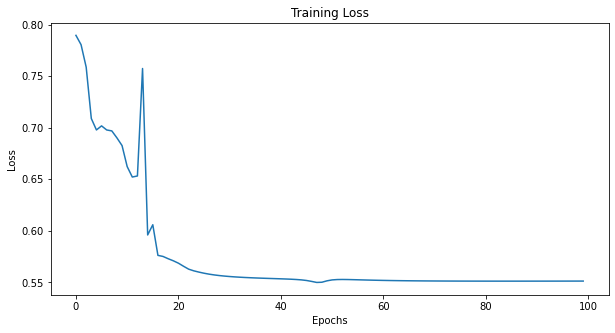

In [15]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,5))

ax.plot(model.training_losses)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.set_title("Training Loss")

g) Print the confusion matrix related to the test set.

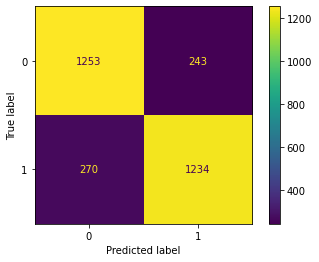

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test_2, y_pred_2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()

<hr>

### **3)** Random forest